# Проект: классификация

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from  sklearn.ensemble import IsolationForest, RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFE
import optuna

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [3]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код

df.info()
df['balance'].isnull().value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


False    11137
True        25
Name: balance, dtype: int64

### Задание 2

In [4]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [5]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)


def to_float(obj):
    if obj is np.nan:
        return obj
    else:
        if ',' in obj:
            return ''.join(('.'.join(obj.rstrip(' $').split(','))).split())
        else:
            return obj.split()[0]

df['balance'] = df['balance'].apply(to_float)
df['balance'] = df['balance'].astype('float32')
df['balance'].mean()

1529.129

### Задание 4

In [6]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
df['balance'] = df['balance'].fillna(df['balance'].median())
df['balance'].mean()

1526.936

### Задание 5

In [7]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
df['job'] = df['job'].apply(lambda x: ''.join(df['job'].mode().tolist()) if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: ''.join(df['education'].mode().tolist()) if x == 'unknown' else x)


In [8]:
df[(df['education'] == 'secondary') & (df['job'] == 'management')]['balance'].mean()

1598.8829

### Задание 6

In [9]:
# удалите все выбросы для признака balance
# ваш код
x = df['balance']
quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
iqr = quartile_3 - quartile_1
lower_bound = quartile_1 - (iqr * 1.5)
upper_bound = quartile_3 + (iqr * 1.5)
display(lower_bound, upper_bound)

-2241.0

4063.0

In [10]:
df_b = df[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)]
df_b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        10105 non-null  int64  
 1   job        10105 non-null  object 
 2   marital    10105 non-null  object 
 3   education  10105 non-null  object 
 4   default    10105 non-null  object 
 5   balance    10105 non-null  float32
 6   housing    10105 non-null  object 
 7   loan       10105 non-null  object 
 8   contact    10105 non-null  object 
 9   day        10105 non-null  int64  
 10  month      10105 non-null  object 
 11  duration   10105 non-null  int64  
 12  campaign   10105 non-null  int64  
 13  pdays      10105 non-null  int64  
 14  previous   10105 non-null  int64  
 15  poutcome   10105 non-null  object 
 16  deposit    10105 non-null  object 
dtypes: float32(1), int64(6), object(10)
memory usage: 1.3+ MB


## Часть 2:  Разведывательный анализ

### Задание 1

In [11]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
display(df_b['deposit'].value_counts())
display(f"максимальный возраст клиента составляет {df_b['age'].max()} лет")
display(f"минимальное количество секунд разговора = {df['duration'].min()}")

no     5424
yes    4681
Name: deposit, dtype: int64

'максимальный возраст клиента составляет 95 лет'

'минимальное количество секунд разговора = 2'

### Задания 2 и 3

In [12]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код

### Задания 4 и 5

In [13]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие 
display(df['month'].nunique())
display(df['job'].nunique())


12

11

In [14]:
df_b['poutcome'].value_counts()

unknown    7570
failure    1109
success     945
other       481
Name: poutcome, dtype: int64

### Задание 6

In [15]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
for i in ['unknown', 'failure', 'success', 'other']:
    display(i)
    display(df_b[df_b['poutcome'] == i]['deposit'].value_counts())

'unknown'

no     4562
yes    3008
Name: deposit, dtype: int64

'failure'

no     562
yes    547
Name: deposit, dtype: int64

'success'

yes    861
no      84
Name: deposit, dtype: int64

'other'

yes    265
no     216
Name: deposit, dtype: int64

### Задание 7

In [16]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
for i in df_b['month'].unique().tolist():
    display(i)
    display(df_b[df_b['month'] == i]['deposit'].value_counts(normalize=True))

'may'

no     0.67864
yes    0.32136
Name: deposit, dtype: float64

'jun'

no     0.548913
yes    0.451087
Name: deposit, dtype: float64

'jul'

no     0.589563
yes    0.410437
Name: deposit, dtype: float64

'aug'

no     0.559567
yes    0.440433
Name: deposit, dtype: float64

'oct'

yes    0.814925
no     0.185075
Name: deposit, dtype: float64

'nov'

no     0.584615
yes    0.415385
Name: deposit, dtype: float64

'dec'

yes    0.903226
no     0.096774
Name: deposit, dtype: float64

'jan'

no     0.60815
yes    0.39185
Name: deposit, dtype: float64

'feb'

yes    0.544429
no     0.455571
Name: deposit, dtype: float64

'mar'

yes    0.898734
no     0.101266
Name: deposit, dtype: float64

'apr'

yes    0.618072
no     0.381928
Name: deposit, dtype: float64

'sep'

yes    0.834532
no     0.165468
Name: deposit, dtype: float64

### Задание 8

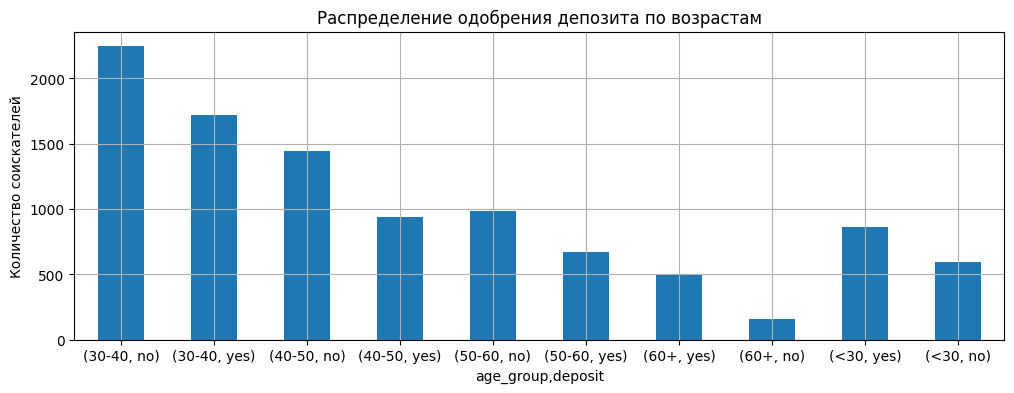

In [17]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def age_group(z):
    if z < 30:
        return '<30'
    elif 30 <= z < 40:
        return '30-40'
    elif 40 <= z < 50:
        return '40-50'
    elif 50 <= z < 60:
        return '50-60'
    else:
        return '60+'

df_b['age_group'] = df['age'].apply(age_group)

age_group_deposit = df_b.groupby(['age_group'])[['deposit']].value_counts()

age_group_deposit.plot( 
    kind='bar', 
    grid=True, 
    figsize=(12, 4), 
    rot=0,
    ylabel='Количество соискателей',
    title='Распределение одобрения депозита по возрастам'
);


### Задания 9 и 10

In [18]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
df_b.groupby(['marital'])['deposit'].value_counts()

marital   deposit
divorced  no          624
          yes         553
married   no         3303
          yes        2412
single    yes        1716
          no         1497
Name: deposit, dtype: int64

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

### Задание 11

In [19]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
df_yes = df_b[df_b['deposit'] == 'yes']
df_no = df_b[df_b['deposit'] == 'no']


In [20]:
df_yes.groupby(['education', 'marital'])['deposit'].value_counts()

education  marital   deposit
primary    divorced  yes          96
           married   yes         339
           single    yes          82
secondary  divorced  yes         283
           married   yes        1289
           single    yes         879
tertiary   divorced  yes         174
           married   yes         784
           single    yes         755
Name: deposit, dtype: int64

In [21]:
df_no.groupby(['education', 'marital'])['deposit'].value_counts()

education  marital   deposit
primary    divorced  no           91
           married   no          641
           single    no          100
secondary  divorced  no          370
           married   no         1830
           single    no          866
tertiary   divorced  no          163
           married   no          832
           single    no          531
Name: deposit, dtype: int64

## Часть 3: преобразование данных

### Задание 1

In [22]:
# преобразуйте уровни образования
label_encoder = LabelEncoder() # указываем столбец для кодирования
df_b['education'] = label_encoder.fit_transform(df_b['education'])
df_b['education'].sum()

11995

In [23]:
df_b['age_group'] = label_encoder.fit_transform(df_b['age_group'])

### Задания 2 и 3

In [24]:
# преобразуйте бинарные переменные в представление из нулей и единиц
for i in ['deposit', 'default', 'housing', 'loan']:
    df_b[i] = df_b[i].apply(lambda x: 1 if x == 'yes' else 0)

In [25]:
df_b.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1,2
1,56,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1,2
2,41,technician,married,1,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1,1
3,55,services,married,1,0,2476.0,1,0,unknown,5,may,579,1,-1,0,unknown,1,2
4,54,admin.,married,2,0,184.0,0,0,unknown,5,may,673,2,-1,0,unknown,1,2


In [26]:
df_b['deposit'].std()

0.4986712532452124

In [27]:
df_b['default'].mean() + df_b['housing'].mean() + df_b['loan'].mean()

0.6354280059376547

### Задание 4

In [28]:
# создайте дамми-переменные
df_dummies = pd.get_dummies(df_b, columns=['job', 'marital', 'contact', 'month', 'poutcome'])
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int32  
 2   default            10105 non-null  int64  
 3   balance            10105 non-null  float32
 4   housing            10105 non-null  int64  
 5   loan               10105 non-null  int64  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int64  
 12  age_group          10105 non-null  int32  
 13  job_admin.         10105 non-null  uint8  
 14  job_blue-collar    10105 non-null  uint8  
 15  job_entrepreneur   10105 non-null  uint8  
 16  job_housemaid      101

### Задания 5 и 6

<Axes: >

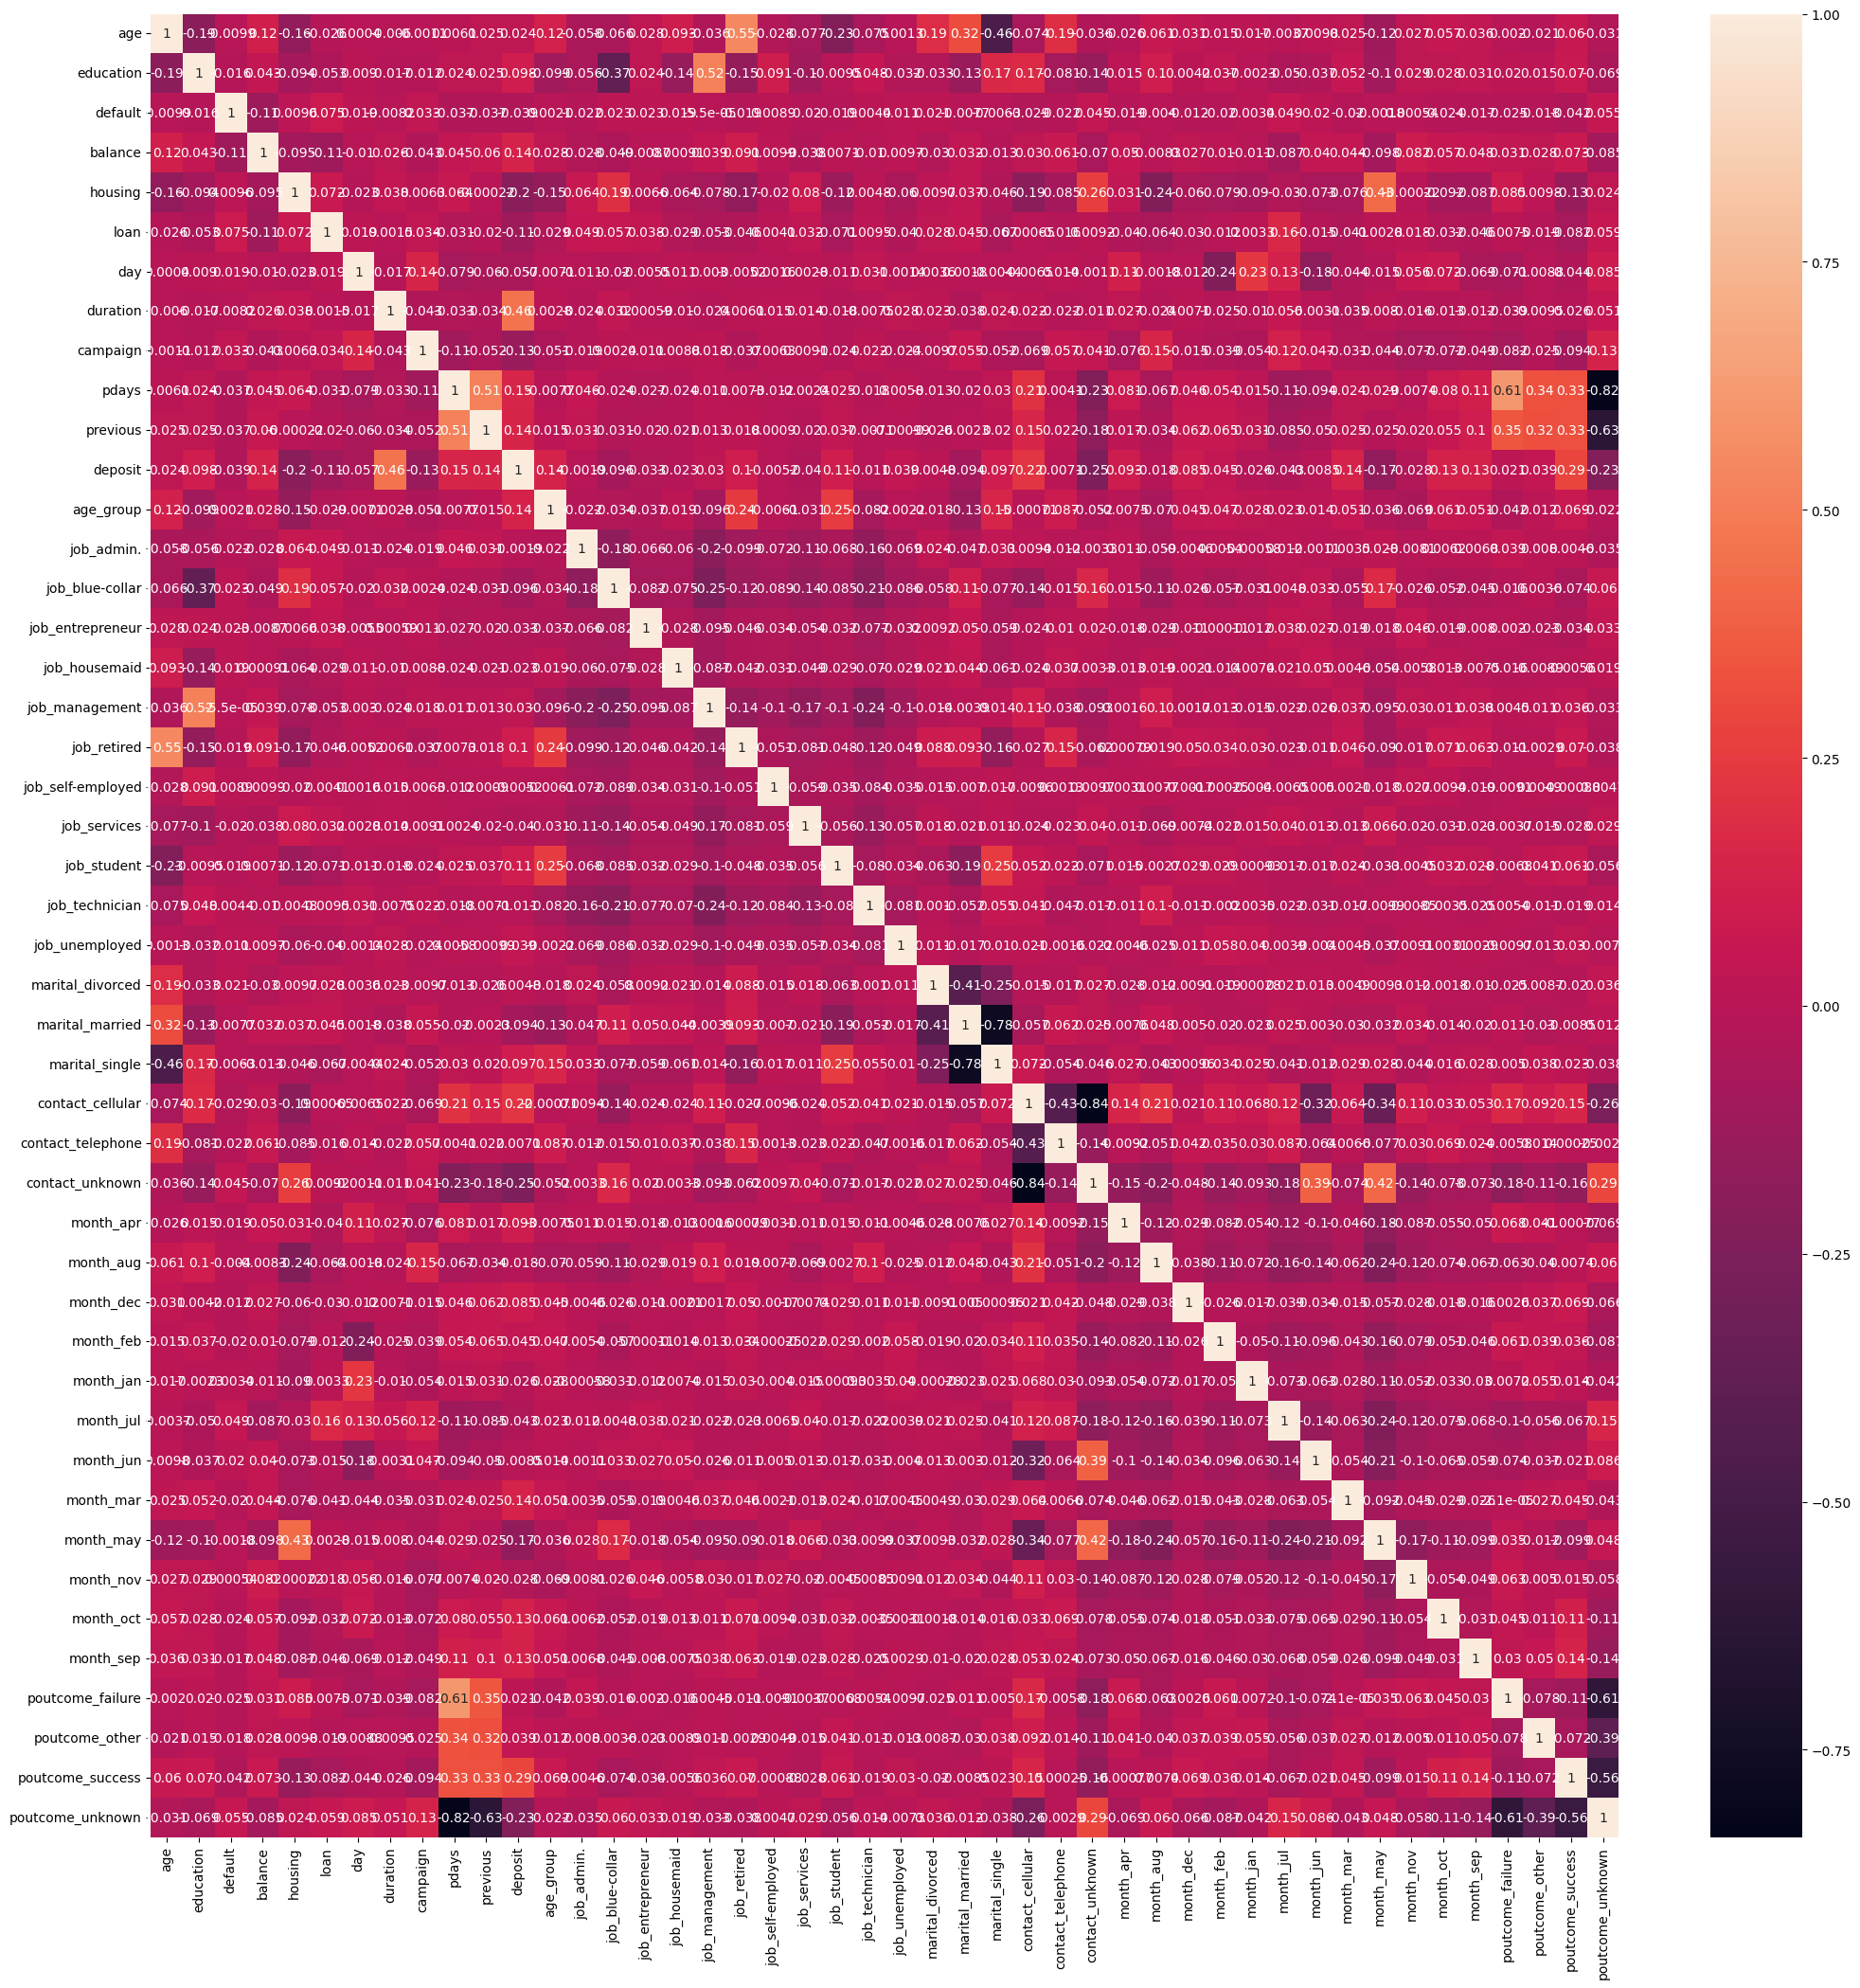

In [29]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
fig, ax = plt.subplots(figsize=(25, 25))
sns.heatmap(df_dummies.corr(), annot=True)

### Задания 7 и 8

In [30]:
X = df_dummies.drop(['deposit'], axis=1)
y = df_dummies['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [31]:
# рассчитайте необходимые показатели
X_test.shape[0]
y_test.mean()

0.46326836581709147

### Задание 9

In [32]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(k=15)
selector.fit(X_train, y_train)
 
selector.get_feature_names_out()

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [33]:
cols = selector.get_feature_names_out().tolist()
X_train_fn = X_train[cols]
X_test_fn = X_test[cols]

In [34]:
X_test_fn.describe()

,balance,housing,duration,campaign,pdays,previous,age_group,contact_cellular,contact_unknown,month_mar,month_may,month_oct,month_sep,poutcome_success,poutcome_unknown
count,3335.000000,3335.000000,3335.000000,3335.000000,3335.000000,3335.000000,3335.000000,3335.000000,3335.000000,3335.000000,3335.000000,3335.000000,3335.000000,3335.000000,3335.000000
mean,812.862976,0.484858,363.887256,2.518441,52.128636,0.841079,1.345427,0.718741,0.209295,0.023688,0.251574,0.031484,0.029385,0.097451,0.743928
std,991.110840,0.499846,338.434555,2.680699,110.965299,2.290651,1.408696,0.449681,0.406867,0.152099,0.433983,0.174649,0.168909,0.296616,0.436527
min,-1944.000000,0.000000,3.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,103.000000,0.000000,134.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,449.000000,0.000000,249.000000,2.000000,-1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1224.000000,1.000000,495.500000,3.000000,27.500000,1.000000,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,4062.000000,1.000000,3094.000000,41.000000,828.000000,55.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Задание 10

In [35]:
# нормализуйте данные с помощью minmaxsxaler
# инициализируем нормализатор MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()

# кодируем исходный датасет
xtrain = mm_scaler.fit_transform(X_train_fn)
xtest = mm_scaler.fit_transform(X_test_fn)
# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
X_train_scaled = pd.DataFrame(xtrain, columns=cols)
X_test_scaled = pd.DataFrame(xtest, columns=cols)

In [36]:
X_test_scaled.describe()

,balance,housing,duration,campaign,pdays,previous,age_group,contact_cellular,contact_unknown,month_mar,month_may,month_oct,month_sep,poutcome_success,poutcome_unknown
count,3335.000000,3335.000000,3335.000000,3335.000000,3335.000000,3335.000000,3335.000000,3335.000000,3335.000000,3335.000000,3335.000000,3335.000000,3335.000000,3335.000000,3335.000000
mean,0.459018,0.484858,0.116754,0.037961,0.064088,0.015292,0.336357,0.718741,0.209295,0.023688,0.251574,0.031484,0.029385,0.097451,0.743928
std,0.165020,0.499846,0.109490,0.067017,0.133854,0.041648,0.352174,0.449681,0.406867,0.152099,0.433983,0.174649,0.168909,0.296616,0.436527
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.340826,0.000000,0.042381,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.398435,0.000000,0.079586,0.025000,0.000000,0.000000,0.250000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.527473,1.000000,0.159334,0.050000,0.034379,0.018182,0.500000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [37]:
# обучите логистическую регрессию и рассчитайте метрики качества

#Создаём объект класса LogisticRegression
log_reg = linear_model.LogisticRegression(solver='sag', max_iter=1000, random_state=42)
#Обучаем модель, минизируя logloss
log_reg.fit(X_train_scaled, y_train)
y_pred = log_reg.predict(X_test_scaled)
acc = metrics.accuracy_score(y_test, y_pred)
acc

0.816191904047976

### Задания 2,3,4

In [38]:
# обучите решающие деревья, настройте максимальную глубину

#Создаём объект класса DecisionTreeClassifier
dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности 
    random_state=42 #генератор случайных чисел
)
#Обучаем дерево решений по алгоритму CART
dt_clf.fit(X_train_scaled, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [39]:
y_pred_2 = dt_clf.predict(X_test_scaled)
acc_2 = metrics.accuracy_score(y_test, y_pred_2)
acc_2

0.7406296851574213

In [40]:
dt_clf.get_depth()

36

In [41]:
y_pred_21 = dt_clf.predict(X_train_scaled)
acc_21 = metrics.accuracy_score(y_train, y_pred_21)
acc_21

1.0

In [42]:
for i in [5, 6, 7]:
    dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности 
    random_state=42, #генератор случайных чисел
    max_depth=i
)
    #Обучаем дерево решений по алгоритму CART
    dt_clf.fit(X_train_scaled, y_train)
    y_pred_i = dt_clf.predict(X_test_scaled)
    acc_i = metrics.accuracy_score(y_test, y_pred_i)
    display( f'depth={i}', acc_i)

'depth=5'

0.7829085457271364

'depth=6'

0.792503748125937

'depth=7'

0.8128935532233883

### Задание 5

In [43]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV

param_grid = {'min_samples_split': [2, 5, 7, 10], 'max_depth':[3,5,7]}

grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(
        #random_state=42, #генератор случайных чисел
        #criterion='entropy'
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)

grid_search.fit(X_train_scaled, y_train)

y_pred_gs = grid_search.predict(X_test_scaled)

print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_pred_gs)))

f1_score на тестовом наборе: 0.80


In [44]:
print("Наилучшие значения параметров: {}".format(grid_search.best_params_))

Наилучшие значения параметров: {'max_depth': 7, 'min_samples_split': 2}


In [45]:
#Создаём объект класса DecisionTreeClassifier
dt_clf_bp = tree.DecisionTreeClassifier(
    #criterion='entropy', #критерий информативности 
    random_state=42, #генератор случайных чисел
    max_depth=7,
    min_samples_split=10
)
#Обучаем дерево решений по алгоритму CART
dt_clf_bp.fit(X_train_scaled, y_train)

y_pred_bp = dt_clf_bp.predict(X_test_scaled)
f1_bp = metrics.f1_score(y_test, y_pred_bp)
f1_bp

0.7951807228915662

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [47]:
# обучите на ваших данных случайный лес
regr2 = RandomForestClassifier(
    max_depth=10, #максимальная глубина дерева
    n_estimators=100, #количество деревьев в ансамбле
    random_state=42, #датчик генератора случайных чисел
    criterion='gini',
    min_samples_leaf=5,
      
)
regr2.fit(X_train_scaled, y_train)



RandomForestClassifier(max_depth=10, min_samples_leaf=5, random_state=42)

In [48]:
y_pred_rf = regr2.predict(X_test_scaled)

In [50]:
print(metrics.classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.88      0.76      0.81      1790
           1       0.76      0.89      0.82      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.82      0.82      3335



### Задания 2 и 3

In [58]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

gb = GradientBoostingClassifier(
    max_depth=5, #максимальная глубина дерева
    n_estimators=300, #количество деревьев в ансамбле
    random_state=42, #датчик генератора случайных чисел
    learning_rate=0.05,
    min_samples_leaf=5,
)

# Обучаем модель
gb.fit(X_train_scaled, y_train)

# Формируем предсказание для тестовой выборки
gb_pred  = gb.predict(X_test_scaled)

# Оцениваем качество по метрикам
print(metrics.classification_report(y_test, gb_pred))
# Будет выведено:


              precision    recall  f1-score   support

           0       0.88      0.76      0.82      1790
           1       0.76      0.88      0.81      1545

    accuracy                           0.81      3335
   macro avg       0.82      0.82      0.81      3335
weighted avg       0.82      0.81      0.81      3335



### Задание 4

In [60]:
# объедините уже известные вам алгоритмы с помощью стекинга 
estimators = [
    ('regr2', RandomForestClassifier(
    max_depth=10, #максимальная глубина дерева
    n_estimators=100, #количество деревьев в ансамбле
    random_state=42, #датчик генератора случайных чисел
    criterion='gini',
    min_samples_leaf=5,
      
)),
    ('gb',  GradientBoostingClassifier(
    max_depth=5, #максимальная глубина дерева
    n_estimators=300, #количество деревьев в ансамбле
    random_state=42, #датчик генератора случайных чисел
    learning_rate=0.05,
    min_samples_leaf=5,
))
]
reg_stack = StackingClassifier(
    estimators=estimators, #базовые модели в стекинге
    final_estimator=linear_model.LogisticRegression(solver='sag',
                                                    max_iter=1000,
                                                    random_state=42)
)
# Обучаем модель
reg_stack.fit(X_train_scaled, y_train)

StackingClassifier(estimators=[('regr2',
                                RandomForestClassifier(max_depth=10,
                                                       min_samples_leaf=5,
                                                       random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=5,
                                                           min_samples_leaf=5,
                                                           n_estimators=300,
                                                           random_state=42))],
                   final_estimator=LogisticRegression(max_iter=1000,
                                                      random_state=42,
                                                      solver='sag'))

In [62]:
# Формируем предсказание для тестовой выборки
y_pred_stack = reg_stack.predict(X_test_scaled)
# Оцениваем качество по метрике precision
print(metrics.classification_report(y_test, y_pred_stack))

              precision    recall  f1-score   support

           0       0.88      0.77      0.82      1790
           1       0.76      0.88      0.82      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задание 5

In [64]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
estimator = GradientBoostingClassifier()
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X_train_scaled, y_train)
 
selector.get_feature_names_out()

array(['duration', 'contact_unknown', 'poutcome_success'], dtype=object)

### Задания 6,7,8

In [67]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

In [69]:
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2023-07-03 22:35:07,005] A new study created in memory with name: RandomForestClassifier
[I 2023-07-03 22:35:07,864] Trial 0 finished with value: 0.8536088930640364 and parameters: {'n_estimators': 170, 'max_depth': 17, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8536088930640364.
[I 2023-07-03 22:35:08,438] Trial 1 finished with value: 0.8506145603529783 and parameters: {'n_estimators': 118, 'max_depth': 10, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8536088930640364.
[I 2023-07-03 22:35:09,183] Trial 2 finished with value: 0.865979381443299 and parameters: {'n_estimators': 137, 'max_depth': 17, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.865979381443299.
[I 2023-07-03 22:35:10,294] Trial 3 finished with value: 0.8779042569780133 and parameters: {'n_estimators': 193, 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.8779042569780133.
[I 2023-07-03 22:35:11,264] Trial 4 finished with value: 0.8779042569780133 and parameters: {'n_es

In [70]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 171, 'max_depth': 21, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.92


In [72]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.82
f1_score на тестовом наборе: 0.82


In [74]:
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1790
           1       0.77      0.89      0.82      1545

    accuracy                           0.82      3335
   macro avg       0.83      0.83      0.82      3335
weighted avg       0.83      0.82      0.82      3335



In [75]:
print(metrics.accuracy_score(y_test, y_test_pred))

0.8221889055472263
